# Discord Clone Tutorial Part 1

## Tutorial part 1: 
* Setting up Convex
* Setting up Clerk
* Setting Friends dashboard

# I. Build Basic Static UI for messaging.

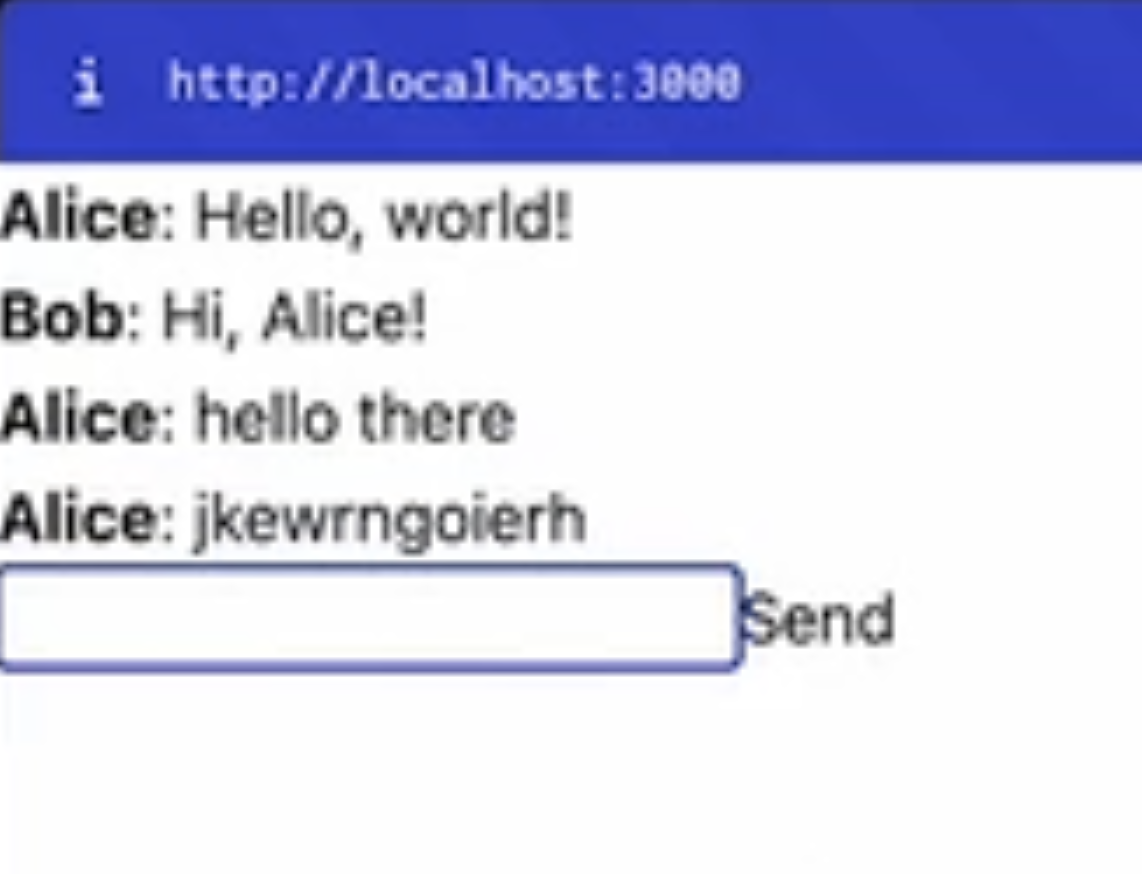

**STEPS**
* Import `useState` from React and define a `Message` interface with `sender` and `content` as string properties.
* Set up messages state using useState, initializing it with sample messages, and create input state as an empty string.
* Create a handleSubmit function to prevent default form behavior, add a new message using the input value, and reset input.
* Render Messages and Input Form:
  * Map over messages to display each message.
  * Add a form with an input field bound to input, an onChange event to update input, and a submit button labeled “Send.”

---
**CODE**: _src/app/page.tsx_

```typescript
import { useState } from "react";

interface Message {
    sender: string;
    content: string;
}

export default function Home() {
  const [messages, setMessages] = useState<Message[]>([
      { sender: 'Alice', content: 'Hello World'},
      { sender: 'Bob', content: "hi, alice!'},
  ]);
  const [input, setInput] = useState("");
    
  const handleSubmit = (event: React.FormEvent<HTMLFormElement>) => {
    event.preventDefault();
    createMessage({ sender: 'Alice', content: input})
    setInput("");
  }
    
  return (
    <>
    <div>
      {messages?.map( (message, index) => (
      <div key={index}>
        <strong>{message.sender}</strong>: {message.content}
      </div>
      ))}
      <form onSubmit={handleSubmit}>
        <input 
          type='text' 
          name='message' 
          id='message' 
          value={input} 
          onChange={e => setInput(e.target.value) }
        />
        <button type='submit'>Send</button>
      </form>

    </div>
    </>
  )
```
---

# II. Add Convex to make our static UI connect to a database

Import convex on your computer. It will open a website to set up your account and initialize your project. It should also added convex files in your project.

_Terminal_ $`pnpm convex dev`

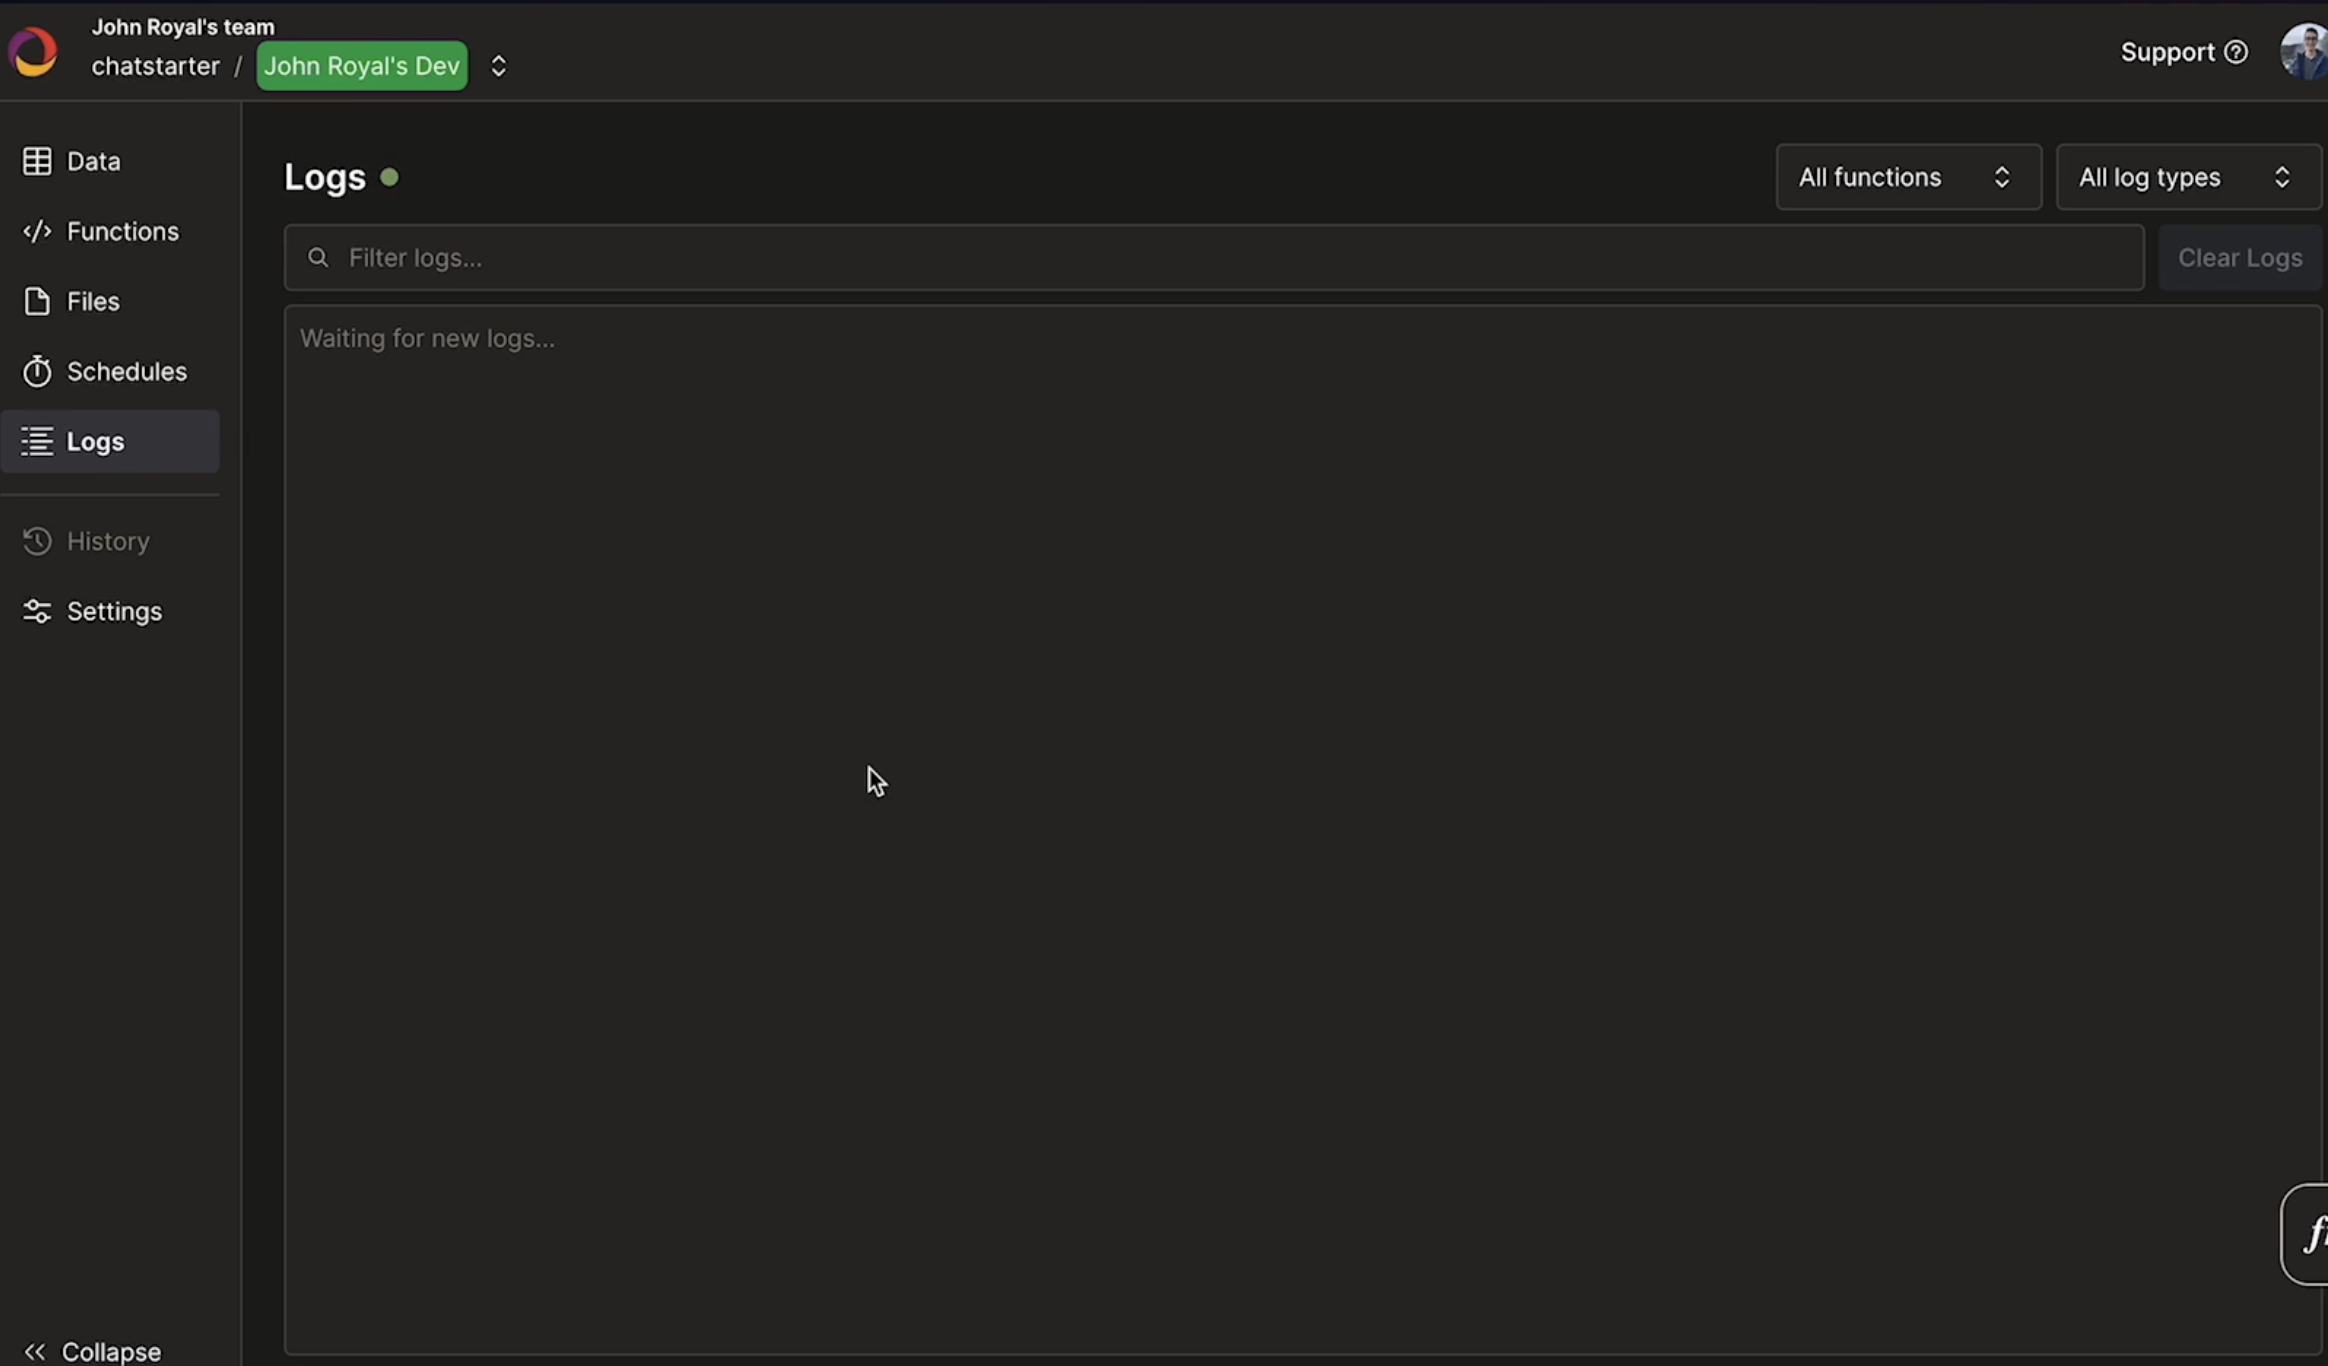

# III. Create a DB Schema

**STEPS**
* To set up a schema for user and message data, start by importing defineSchema and defineTable from "convex/server", and the v validation utility from "convex/values".
* Use defineSchema to define tables for messages. Define fields sender and content, both also validated as strings. 

---
**CODE**_: convex/schema.ts_

```typescript
import { defineSchema, defineTable } from "convex/server";
import { v } from "convex/values";

export default defineSchema({
    messages: defineTable({
        sender: v.string(),
        content: v.string(),
    })
});
```
---

# IV. Define functions to interact with messages table through Convex
**SOURCE**: [Convex queries](https://docs.convex.dev/functions/query-functions)  |  [Convex mutation](https://docs.convex.dev/functions/mutation-functions)

**Queries**: fetch data from the database, check authentication or peform other business logic, and return data back to the client application. The same rules apply to mutations and actions, while HTTP actions use a different routing approach.

**Query Constructor**: To actually declare a `query` in Convex you use the query constructor function. Pass it an object with a `handler` function, which returns the query result.

**Query Arguments**: Queries accept named arguments. The argument values are accessible as fields of the second parameter of the handler function. Arguments and responses are automatically serialized and deserialized, and you can pass and return most value-like JavaScript data to and from your query. To both declare the types of arguments and to validate them, add an args object using v validators.

**Query Context**: The query constructor enables fetching data, and other Convex features by passing a QueryCtx object to the handler function as the first parameter. Which part of the query context is used depends on what your query needs to do:
* Fetch from the database use the `db` field. Note that we make the handler function an `async` function so we can `await` the promise returned by `db.get()`:
* Return URLs to stored files use the storage field.
* Check user authentication use the auth field.

**Mutations**: Mutations insert, update and remove data from the database, check authentication or perform other business logic, and optionally return a response to the client application.

---
**CODE**: _convex/functions/message.ts_

```typescript
import { mutation, query } from "../_generated/server";
import { v } from 'convex/values';

export const list = query({
    handler: async (ctx) => {
        return await ctx.db.query("messages").collect();
    },
});

export const create = mutation({
    args: {
        sender: v.string(),
        content: v.string(),
    },
    handler: async (ctx, { sender, content}) => {
        await ctx.db.insert('messages', { sender, content });
    },
})
```
---
**CODE**: _convex/functions/user.ts_

```typescript
import { 
    internalMutation, 
    MutationCtx, 
    query, 
    QueryCtx } from '../_generated/server';
import { v } from 'convex/values';

export const get = query({
    handler: async (ctx) => {
        return await getCurrentUser(ctx);
    },
})

export const upsert = internalMutation({
    args: { 
        username: v.string(),
        image: v.string(),
        clerkId: v.string(),
    },
    handler: async (ctx, args) => {
        const user = await getUserByClerkid(ctx, args.clerkId)

        // If user is found, update. Otherwise, create new user
        if (user) {
            await ctx.db.patch(user._id, {
                username: args.username,
                image: args.image,
            })
        } else {
            await ctx.db.insert('users', {
                username: args.username,
                image: args.image,
                clerkId: args.clerkId,
            });
        }
    },
});

export const remove = internalMutation({
    args: { clerkId: v.string() },
    handler: async (ctx, args) => {
        const user = await getUserByClerkid(ctx, args.clerkId)

        // If user is found, delete.
        if (user) {
            await ctx.db.delete(user._id);
        }
    },
})

const getCurrentUser = async (ctx: QueryCtx | MutationCtx) => {
    const identity = await ctx.auth.getUserIdentity();
    if (!identity) {
        return null;
    }
    return await getUserByClerkid(ctx, identity.subject)
}

const getUserByClerkid = async (
    ctx: QueryCtx | MutationCtx, 
    clerkId: string
) => {
    return await ctx.db
        .query('users')
        .withIndex('by_clerk_id', (q) => q.eq('clerkId', clerkId))
        .unique();
}
```
---